# GET dT/dY for a TR case. 

In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must include .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
data_folder = "/Volumes/ThermalAmp/TR=1.6/"

#from cmcrameri import cm

In [3]:
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]

In [4]:
# Define constants
tw = 308
yw = -0.015

# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
data_files = [f for f in data_files if "/._" not in f]

def get_time(data_file):
    #return float(data_file.split(".")[0].split("-")[-1])  #My directories
    #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)

In [17]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]

def get_interpolated_contour(node_x, node_y, data_file):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """

    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        #U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        #V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        from scipy.interpolate import griddata
        SI = griddata((node_x, node_y), T, (xgrid, ygrid), method='nearest', fill_value=np.nan)
        return SI



Plot the nodes with U,V,T

In [6]:
timestep = 0
import time


timestep = 0
fname = os.path.join(data_folder, data_files[timestep])

# Read temperature and velocity data from the HDF5 file
with h5py.File(fname, 'r') as f:
    T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
    U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
    V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]


# Start timer
start_time = time.time()

fname = os.path.join(data_folder, data_files[timestep])
SI = get_interpolated_contour(node_x, node_y, data_file=fname)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Elapsed time: 4.997651 seconds


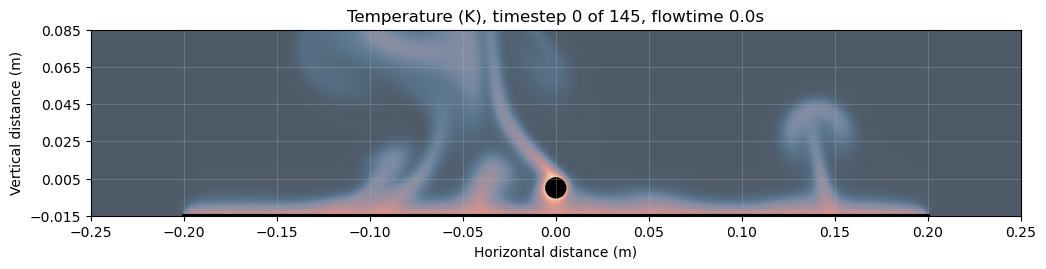

In [8]:
# Proof that they are mapped properly
fig, ax = plt.subplots(figsize=(12,3))
p_ = ax.imshow(SI, extent=[XMIN, XMAX, YMIN, YMAX], alpha=0.7, cmap=cm.lipari) #cmap='Greys')
ax.set_title("Temperature (K), timestep {} of {}, flowtime {}s".format(timestep, len(data_files), timestep*0.05*2))

plt.plot(np.arange(-0.2, 0.21, 0.01), np.ones((np.arange(-0.2, 0.21, 0.01).shape))*-0.015, color='k', linewidth=3)
plt.ylim([-0.015, 0.085])
plt.xlim([-0.25, 0.25])
plt.gca().set_aspect('equal')

# Manually set x ticks and labels
x_ticks = np.arange(-0.25, 0.26, 0.05)
x_labels = ['Zero', 'One', 'Two', 'Three']
ax.set_xticks(x_ticks)
# Manually set y ticks and labels
y_ticks = np.arange(-0.015, 0.086, 0.02)
y_labels = ['Zero', 'Three', 'Six', 'Nine']
ax.set_yticks(y_ticks)

circle = patches.Circle((0,0), radius=0.005, edgecolor='k', facecolor='k', linewidth=2)

plt.grid(alpha=0.3)
plt.xlabel("Horizontal distance (m)")
plt.ylabel("Vertical distance (m)")

# Add the circle to the axis
ax.add_patch(circle)


In [11]:
def get_Qavg(SI):

    Tw = 308
    Height = 0.015
    CylinderDiameter = 0.01
    HeightOverDiamter = Height/CylinderDiameter

    Yw = -HeightOverDiamter*CylinderDiameter

    # Define the combined condition for masking
    mask_condition = (ygrid < Yw/1.02) & (xgrid < 0.2) & (xgrid > -0.2)
    y_ = np.unique(ygrid[ygrid <= -0.0147] )
    x_ = np.unique(xgrid[(xgrid < 0.2) & (xgrid > -0.2)])

    # Apply the mask to SI
    SI_masked = np.copy(SI)
    SI_masked[~mask_condition] = np.nan

    Y_ = np.unique(ygrid[ygrid <= Yw/1.02] )
    Y1 = Y_[-1]
    Y2 = Y_[-2]
    Y3 = Y1**2
    Y4 = Y2**2
    K_ThermalConductivity = 0.02225
    dTdy = []

    left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
    right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]
    SI_slice = SI_masked[:, left_wall_ind:right_wall_ind]

    for c in range(SI_slice.shape[1]):
        T1 = SI_slice[-1, c]
        T2 = SI_slice[-2, c]
        dTdy_value = (T1 * Y4 - T2 * Y3 - Tw * (Y4 - Y3)) / (Y1 * Y4 - Y2 * Y3)
        dTdy.append(dTdy_value)
    Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)
    return Qavg


In [18]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning
        
# Use LokyBackend tso protect the h5py routine
SIs = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(get_interpolated_contour) \
 (node_x, node_y, data_file
 ) for data_file in data_files)

env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:  1.9min finished


In [23]:

SI_list = SIs
# Calculate the average SI across the first dimension
chunk_size = 50  # Adjust based on your memory capacity
num_chunks = len(SI_list) // chunk_size + (len(SI_list) % chunk_size > 0)

average_SI = np.zeros_like(SI_list[0])  # Initialize for averaging
for i in range(num_chunks):
    chunk = SI_list[i * chunk_size : (i + 1) * chunk_size]
    average_SI += np.sum(chunk, axis=0)

average_SI /= len(SI_list)  # Final averaging

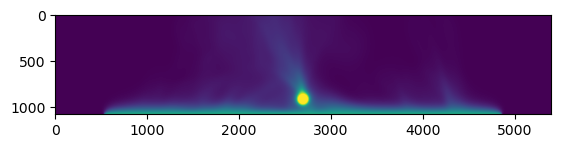

In [24]:
plt.imshow(average_SI)

In [25]:
get_Qavg(average_SI) #in W/m^2 per post file.

-18.342160546493844